<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*The design of the primary structure of an airframe begins with establishing the air loads it will experience in service. These vary mainly with airspeed and the amount of lift demanded of the lifting surfaces throughout the range of manoeuvres flown by the aircraft.*

*The airspeed versus load factor (V-n) diagram is a concise representation of the closed set of boundaries that surround all the loading conditions the aircraft is expected to withstand. The algorithm for drawing up this **flight envelope** is usually set out by the certification document that defines the initial airworthiness requirements. In this notebook we base our discussion of the flight envelope (and how to draw it up in ADRpy) on the algorithm included in EASA's CS-23.*

# The Flight Envelope of a Fixed Wing Aircraft

For the purposes certifying the airworthiness of an aircraft from the perspective of its structural strength, the 'flight envelope' is generally depicted as a closed set of boundaries in the V (equivalent airspeed) - n (load factor) space. The pictorial representation of this area, whithin which compliance with structural strength requirements has to be demonstrated as part of the certification process, is referred to as the **V-n diagram** of the aircraft.

The V-n diagram specifies the limit loads due to symmetrical manoeuvres and gust loads (which the airframe has to be able to withstand at any combination of equivalent airspeed and load factor within the flight envelope); other structural loads (landing, bird strike, etc.) must be dealt with separately.

## Illustrative example

In [1]:
from ADRpy import airworthiness as aw
from ADRpy import atmospheres as at
from ADRpy import constraintanalysis as ca
from ADRpy import unitconversions as co

In [2]:
designbrief = {"vstallclean_kcas": 46.3}

In [3]:
b_ft, S_ft2 = 38, 130

designdef = {
    "aspectratio": b_ft ** 2 / S_ft2,
    "weight_n": co.lbf2n(1320)
}

In [4]:
designperf = {
    "CLalpha": 5.25, "CLmax": 1.45, "CLmin": -1.00,
    # "CLmaxHL": 2.10, "CLminHL": -0.75  # <-- Not implemented yet!
}

In [5]:
designpropulsion = None

In [6]:
designatm = at.Atmosphere()

In [7]:
concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdef,
    performance=designperf,
    atmosphere=designatm,
    propulsion=designpropulsion
)

In [8]:
cs23eval = aw.CS23Amendment4(concept, "normal", co.feet22m2(S_ft2))

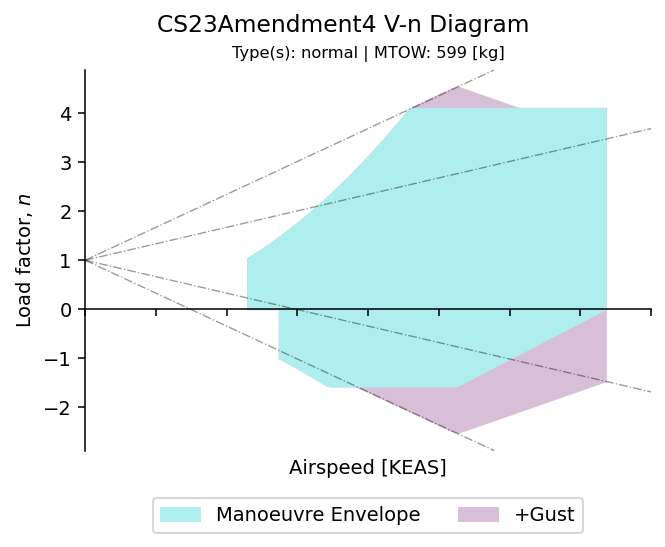

In [9]:
fig, ax = cs23eval.plot_Vn()